## 1. Import libraries

In [31]:
import rasterio
import numpy as np
import random
import os
import torch
import pandas as pd
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from loss_fn import FocalLoss, iou_pytorch

## 2. Config

In [32]:
config={
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'seed':10,
    'val_size':0.3,
    'channels':[6,5,2],
    'experiment':True,
    'batch_size':8,
    'lr':1e-3,
    'epochs':50,
    'early_stopping':15,
    'inference':{
        'threshold':0.25
    }
}
DATAPATH='./dataset'
data_paths={
    'train_csv': DATAPATH+'/train_meta_1.csv',
    'test_csv': DATAPATH+'/test_meta.csv',
    'train_img':DATAPATH+'/train_img/',
    'train_mask':DATAPATH+'/train_mask/',
    'test_img':DATAPATH+'/test_img/',
}
train_csv = pd.read_csv(data_paths['train_csv'])
SAVE_PATH = './logs'
save_paths={
    'model':SAVE_PATH+'/models/',
    'val':SAVE_PATH+'/vals/'
}
# 시드 고정 함수
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
fix_seed(config['seed'])

## 3. Load Data

In [33]:
class Wildfire_Dataset(Dataset):
    def __init__(self, csv, transform_f=None,infer=False):
        self.csv = csv
        self.transform_f = transform_f
        self.infer = infer
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self,idx):
        img_path = self.csv.iloc[idx,0]
        # test인 경우 infer==True
        if self.infer:
            image = rasterio.open(data_paths['test_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
            image = image/(2**16)
            if self.transform_f:
                image = self.transform_f(image=image)['image']
            return image
        # train인 경우
        image = rasterio.open(data_paths['train_img']+img_path).read().transpose(1,2,0)[:,:,config['channels']]
        image = image/(2**16)
        mask_path = self.csv.iloc[idx,1]
        mask = rasterio.open(data_paths['train_mask']+mask_path).read().transpose(1,2,0)
        if self.transform_f:
            augmented = self.transform_f(image=image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

In [34]:
base_transforms = {
    'train': A.Compose([
        # A.RandomBrightnessContrast(contrast_limit=(2,2),p=1),
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'valid':A.Compose([
        A.Normalize((0.5, ), (0.5, )),
        ToTensorV2(transpose_mask=True)
    ]),
    'test':A.Compose([
        A.Normalize((0.5, ), (0.5, )),      
        ToTensorV2(transpose_mask=True)
    ]),
}

In [35]:
fix_seed(config['seed'])
train_csv_, valid_csv_ = train_test_split(train_csv,test_size=config['val_size'],random_state=config['seed'])
train_dataset = Wildfire_Dataset(train_csv_,transform_f=base_transforms['train'],infer=False)
valid_dataset = Wildfire_Dataset(valid_csv_,transform_f=base_transforms['valid'],infer=False)
# B,C,H,W

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'],shuffle=False)
print(f'train size: {len(train_dataset)}, valid size: {len(valid_dataset)}')

train size: 14, valid size: 6


Augmentation Result Viewer

torch.Size([8, 3, 256, 256])


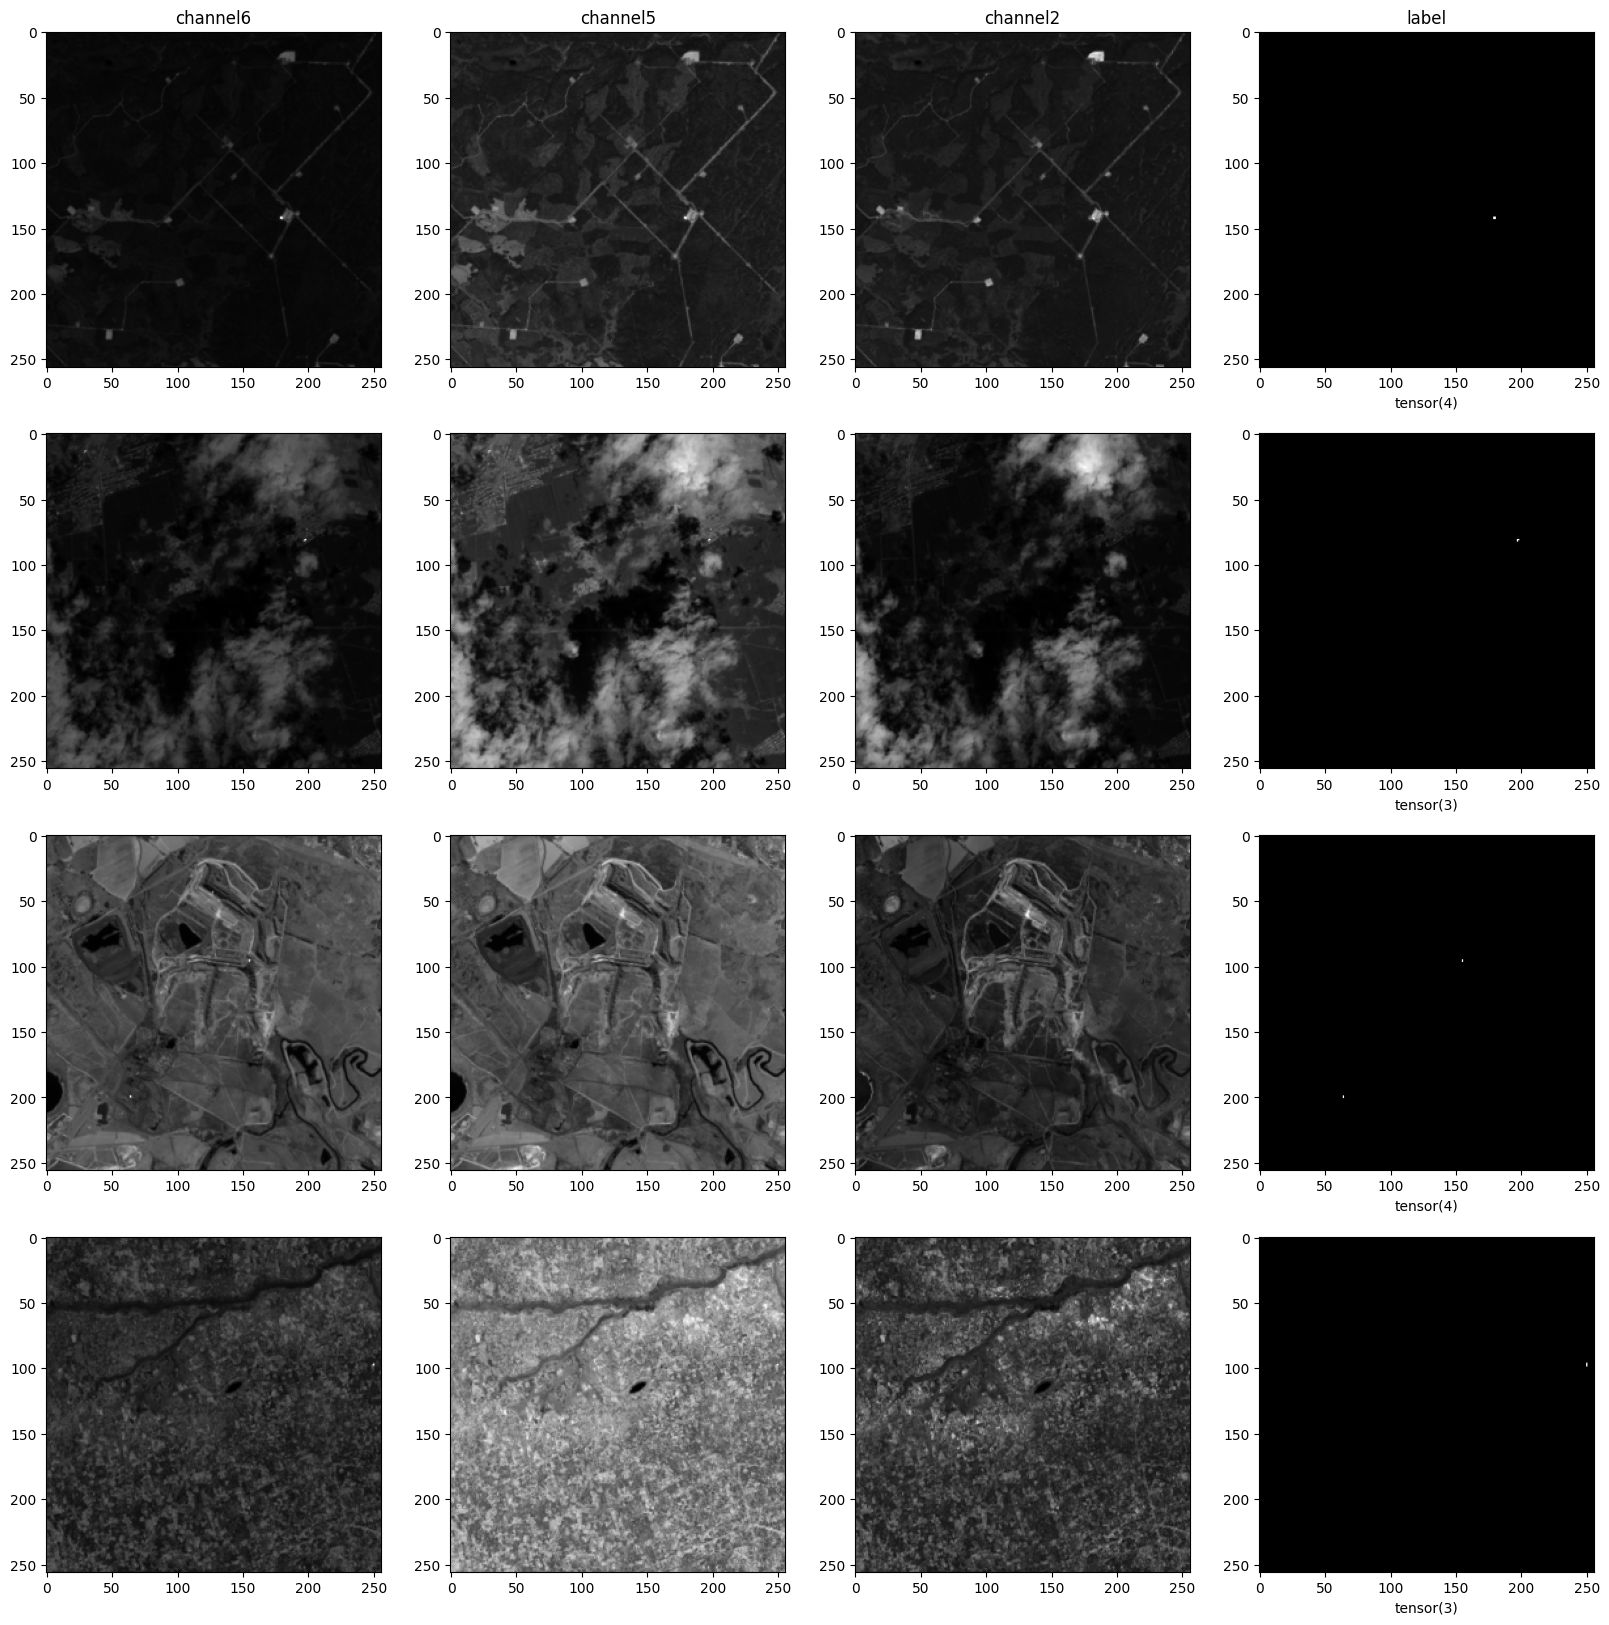

In [36]:
num_imgs_to_show=4
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')

cnt=0
for idx,(imgs, masks) in enumerate(train_loader):
    print(imgs.shape)
    for i in range(len(imgs)):
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-1].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-1].set_xlabel(str(masks[i,0,:,:].sum().sum()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 4. Modeling

In [37]:
import segmentation_models_pytorch as smp
# from fcn_model import FCN

In [38]:
model = smp.Unet(
    encoder_name='efficientnet-b4',
    encoder_weights = 'imagenet',
    in_channels=len(config['channels']),
    classes=1,
)
# model = FCN()
torch.save(model.state_dict(), save_paths["model"]+'/base_model.pt')

## 5. Train/Validation

In [39]:
def validation(config, model, criterion, valid_loader,epoch):
    model.eval()
    valid_loss=0
    valid_iou_score = 0
    y_pred_dict={}
    with torch.no_grad():
        for idx,(images, masks) in tqdm(enumerate(valid_loader)):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            valid_iou_score+=iou_pytorch(outputs,masks,threshold=config['inference']['threshold'])
            valid_loss +=loss.item()
            
            for i in range(len(outputs)):
                y_pred = np.where(outputs[i,0,:,:].to('cpu')>config['inference']['threshold'],1,0).astype(np.uint8)
                y_pred_dict[str(idx*config['batch_size']+i)] = y_pred
        valid_save_path = save_paths['val']+f'epoch_{epoch}.pkl'
        joblib.dump(y_pred_dict,valid_save_path)
    return valid_loss/len(valid_loader), valid_iou_score/len(valid_loader)

In [40]:
def train(config, model, train_loader, valid_loader):
    model = model.to(config['device'])
    es_count = 0
    min_val_loss = float('inf')
    best_model = None
    
    criterion = FocalLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = config['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-8, verbose=True)
    print('***TRAINING START***')
    for epoch in range(config['epochs']):
        model.train()
        epoch_loss=0
        epoch_iou = 0
        for images, masks in tqdm(train_loader):
            images = images.to(config['device'],dtype = torch.float32)
            masks = masks.to(config['device'],dtype = torch.float32)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            epoch_iou+=iou_pytorch(outputs,masks,threshold=config['inference']['threshold'])
            
            optimizer.step()
            
            epoch_loss+=loss.item()
        
        val_loss,val_iou = validation(config, model, criterion, valid_loader, epoch)
        
        es_count += 1
        if min_val_loss > val_loss:
            es_count = 0
            min_val_loss = val_loss
            best_model = model
            state_dict = model.state_dict()
            best_epoch = epoch+1
            print(f"Epoch [{best_epoch}] New Minimum Valid Loss!")
            print("..save current best model..")
            model_name = f'epoch {epoch}_current_best_model.pt'
            torch.save(state_dict, save_paths['model']+'/'+model_name)
        
        scheduler.step(val_loss)
        
        if es_count == config['early_stopping']:
            print(f"Early Stopping Count에 도달했습니다!")
            print(f"Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Train IoU: {epoch_iou/len(train_loader):6f}, Valid Loss: {val_loss:6f}, Valid_iou: {val_iou:6f} Best Epoch: {best_epoch}")
            print("***TRAINING DONE***")
            return best_model
        print(f"Epoch {epoch+1}, Train Loss: {(epoch_loss/len(train_loader)):6f}, Train IoU: {epoch_iou/len(train_loader):6f}, Valid Loss: {val_loss:6f}, Valid_iou: {val_iou:6f}, ES Count: {es_count}")
        print("------------------------------------------------------------------------------------")
    print(f"Early Stopping Count에 도달하지 않았습니다! \nEarly Stopping Count: {config['early_stopping']} Best Epoch: {best_epoch}")
    print("***TRAINING DONE***")
    return best_model

In [41]:
best_model = train(config,model,train_loader,valid_loader)

/home/cvip-09/anaconda3/envs/aispark/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


***TRAINING START***


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.95it/s]
1it [00:00,  9.78it/s]


Epoch [1] New Minimum Valid Loss!
..save current best model..
Epoch 1, Train Loss: 0.603486, Train IoU: 0.000060, Valid Loss: 0.135029, Valid_iou: 0.000124, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
1it [00:00,  9.75it/s]


Epoch [2] New Minimum Valid Loss!
..save current best model..
Epoch 2, Train Loss: 0.422592, Train IoU: 0.000057, Valid Loss: 0.087749, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.85it/s]
1it [00:00,  6.85it/s]


Epoch 3, Train Loss: 0.306811, Train IoU: 0.000057, Valid Loss: 0.130966, Valid_iou: 0.000000, ES Count: 1
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]
1it [00:00, 10.75it/s]


Epoch 4, Train Loss: 0.231835, Train IoU: 0.000017, Valid Loss: 0.168776, Valid_iou: 0.000000, ES Count: 2
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.34it/s]
1it [00:00, 10.51it/s]


Epoch 5, Train Loss: 0.180838, Train IoU: 0.000020, Valid Loss: 0.165322, Valid_iou: 0.000000, ES Count: 3
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]
1it [00:00,  9.68it/s]


Epoch 6, Train Loss: 0.143596, Train IoU: 0.000000, Valid Loss: 0.159672, Valid_iou: 0.000000, ES Count: 4
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]
1it [00:00,  9.04it/s]


Epoch 7, Train Loss: 0.116347, Train IoU: 0.000106, Valid Loss: 0.142059, Valid_iou: 0.000000, ES Count: 5
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
1it [00:00, 10.33it/s]


Epoch 8, Train Loss: 0.095484, Train IoU: 0.000000, Valid Loss: 0.123307, Valid_iou: 0.000000, ES Count: 6
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]
1it [00:00, 10.58it/s]


Epoch 9, Train Loss: 0.079790, Train IoU: 0.000000, Valid Loss: 0.107478, Valid_iou: 0.000000, ES Count: 7
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]
1it [00:00, 10.64it/s]


Epoch 10, Train Loss: 0.074004, Train IoU: 0.000000, Valid Loss: 0.095345, Valid_iou: 0.000000, ES Count: 8
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.22it/s]
1it [00:00,  8.71it/s]


Epoch [11] New Minimum Valid Loss!
..save current best model..
Epoch 11, Train Loss: 0.066249, Train IoU: 0.000000, Valid Loss: 0.084255, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
1it [00:00, 10.52it/s]


Epoch [12] New Minimum Valid Loss!
..save current best model..
Epoch 12, Train Loss: 0.060395, Train IoU: 0.000000, Valid Loss: 0.073582, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.80it/s]
1it [00:00, 10.11it/s]


Epoch [13] New Minimum Valid Loss!
..save current best model..
Epoch 13, Train Loss: 0.055814, Train IoU: 0.000000, Valid Loss: 0.064320, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
1it [00:00,  9.90it/s]


Epoch [14] New Minimum Valid Loss!
..save current best model..
Epoch 14, Train Loss: 0.051678, Train IoU: 0.000000, Valid Loss: 0.056718, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.25it/s]
1it [00:00,  9.75it/s]


Epoch [15] New Minimum Valid Loss!
..save current best model..
Epoch 15, Train Loss: 0.047299, Train IoU: 0.000000, Valid Loss: 0.050040, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]
1it [00:00,  8.93it/s]


Epoch [16] New Minimum Valid Loss!
..save current best model..
Epoch 16, Train Loss: 0.044518, Train IoU: 0.000000, Valid Loss: 0.043804, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.21it/s]
1it [00:00, 10.04it/s]


Epoch [17] New Minimum Valid Loss!
..save current best model..
Epoch 17, Train Loss: 0.039591, Train IoU: 0.000000, Valid Loss: 0.038746, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]
1it [00:00,  9.87it/s]


Epoch [18] New Minimum Valid Loss!
..save current best model..
Epoch 18, Train Loss: 0.038760, Train IoU: 0.000000, Valid Loss: 0.033352, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
1it [00:00, 10.28it/s]


Epoch [19] New Minimum Valid Loss!
..save current best model..
Epoch 19, Train Loss: 0.034685, Train IoU: 0.000000, Valid Loss: 0.029739, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]
1it [00:00,  9.53it/s]


Epoch [20] New Minimum Valid Loss!
..save current best model..
Epoch 20, Train Loss: 0.032215, Train IoU: 0.000000, Valid Loss: 0.026347, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.78it/s]
1it [00:00,  9.74it/s]


Epoch [21] New Minimum Valid Loss!
..save current best model..
Epoch 21, Train Loss: 0.032325, Train IoU: 0.000000, Valid Loss: 0.024160, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]
1it [00:00,  9.83it/s]


Epoch [22] New Minimum Valid Loss!
..save current best model..
Epoch 22, Train Loss: 0.028029, Train IoU: 0.000000, Valid Loss: 0.022077, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.17it/s]
1it [00:00,  9.84it/s]


Epoch [23] New Minimum Valid Loss!
..save current best model..
Epoch 23, Train Loss: 0.025353, Train IoU: 0.000000, Valid Loss: 0.019920, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]
1it [00:00,  9.38it/s]


Epoch [24] New Minimum Valid Loss!
..save current best model..
Epoch 24, Train Loss: 0.023734, Train IoU: 0.000000, Valid Loss: 0.018308, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]
1it [00:00,  9.42it/s]


Epoch [25] New Minimum Valid Loss!
..save current best model..
Epoch 25, Train Loss: 0.021737, Train IoU: 0.000000, Valid Loss: 0.016621, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.15it/s]
1it [00:00, 10.07it/s]


Epoch [26] New Minimum Valid Loss!
..save current best model..
Epoch 26, Train Loss: 0.020824, Train IoU: 0.000000, Valid Loss: 0.015024, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]
1it [00:00, 10.19it/s]


Epoch [27] New Minimum Valid Loss!
..save current best model..
Epoch 27, Train Loss: 0.019148, Train IoU: 0.000000, Valid Loss: 0.013764, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
1it [00:00, 10.03it/s]


Epoch [28] New Minimum Valid Loss!
..save current best model..
Epoch 28, Train Loss: 0.018923, Train IoU: 0.000000, Valid Loss: 0.013010, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]
1it [00:00,  9.74it/s]


Epoch [29] New Minimum Valid Loss!
..save current best model..
Epoch 29, Train Loss: 0.016459, Train IoU: 0.000000, Valid Loss: 0.011836, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]
1it [00:00, 10.12it/s]


Epoch [30] New Minimum Valid Loss!
..save current best model..
Epoch 30, Train Loss: 0.015364, Train IoU: 0.000000, Valid Loss: 0.010675, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]
1it [00:00,  9.69it/s]


Epoch [31] New Minimum Valid Loss!
..save current best model..
Epoch 31, Train Loss: 0.014608, Train IoU: 0.000000, Valid Loss: 0.009850, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
1it [00:00,  9.61it/s]


Epoch [32] New Minimum Valid Loss!
..save current best model..
Epoch 32, Train Loss: 0.013672, Train IoU: 0.000000, Valid Loss: 0.009087, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]
1it [00:00, 10.00it/s]


Epoch [33] New Minimum Valid Loss!
..save current best model..
Epoch 33, Train Loss: 0.013428, Train IoU: 0.000000, Valid Loss: 0.008478, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.06it/s]
1it [00:00, 10.54it/s]


Epoch [34] New Minimum Valid Loss!
..save current best model..
Epoch 34, Train Loss: 0.011965, Train IoU: 0.000000, Valid Loss: 0.007769, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
1it [00:00,  9.70it/s]


Epoch [35] New Minimum Valid Loss!
..save current best model..
Epoch 35, Train Loss: 0.012148, Train IoU: 0.000000, Valid Loss: 0.007188, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
1it [00:00,  9.89it/s]


Epoch [36] New Minimum Valid Loss!
..save current best model..
Epoch 36, Train Loss: 0.012444, Train IoU: 0.000000, Valid Loss: 0.007043, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.11it/s]
1it [00:00, 10.08it/s]


Epoch [37] New Minimum Valid Loss!
..save current best model..
Epoch 37, Train Loss: 0.010913, Train IoU: 0.000000, Valid Loss: 0.006564, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]
1it [00:00, 10.01it/s]


Epoch [38] New Minimum Valid Loss!
..save current best model..
Epoch 38, Train Loss: 0.010092, Train IoU: 0.000000, Valid Loss: 0.006203, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]
1it [00:00,  9.90it/s]


Epoch [39] New Minimum Valid Loss!
..save current best model..
Epoch 39, Train Loss: 0.009440, Train IoU: 0.000000, Valid Loss: 0.005687, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.13it/s]
1it [00:00,  9.80it/s]


Epoch [40] New Minimum Valid Loss!
..save current best model..
Epoch 40, Train Loss: 0.009427, Train IoU: 0.000000, Valid Loss: 0.005389, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.72it/s]
1it [00:00,  9.57it/s]


Epoch [41] New Minimum Valid Loss!
..save current best model..
Epoch 41, Train Loss: 0.008797, Train IoU: 0.000000, Valid Loss: 0.005112, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]
1it [00:00,  9.58it/s]


Epoch [42] New Minimum Valid Loss!
..save current best model..
Epoch 42, Train Loss: 0.008371, Train IoU: 0.000000, Valid Loss: 0.004836, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
1it [00:00,  9.67it/s]


Epoch [43] New Minimum Valid Loss!
..save current best model..
Epoch 43, Train Loss: 0.008155, Train IoU: 0.000000, Valid Loss: 0.004559, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.90it/s]
1it [00:00,  9.65it/s]


Epoch [44] New Minimum Valid Loss!
..save current best model..
Epoch 44, Train Loss: 0.007749, Train IoU: 0.000000, Valid Loss: 0.004314, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.05it/s]
1it [00:00,  9.62it/s]


Epoch [45] New Minimum Valid Loss!
..save current best model..
Epoch 45, Train Loss: 0.007449, Train IoU: 0.000000, Valid Loss: 0.004070, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.06it/s]
1it [00:00,  9.24it/s]


Epoch [46] New Minimum Valid Loss!
..save current best model..
Epoch 46, Train Loss: 0.007425, Train IoU: 0.000000, Valid Loss: 0.004014, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
1it [00:00,  9.79it/s]


Epoch [47] New Minimum Valid Loss!
..save current best model..
Epoch 47, Train Loss: 0.006920, Train IoU: 0.000000, Valid Loss: 0.003931, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]
1it [00:00,  9.30it/s]


Epoch [48] New Minimum Valid Loss!
..save current best model..
Epoch 48, Train Loss: 0.006887, Train IoU: 0.000000, Valid Loss: 0.003757, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  4.20it/s]
1it [00:00,  9.26it/s]


Epoch [49] New Minimum Valid Loss!
..save current best model..
Epoch 49, Train Loss: 0.006510, Train IoU: 0.000000, Valid Loss: 0.003614, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.98it/s]
1it [00:00,  9.71it/s]


Epoch [50] New Minimum Valid Loss!
..save current best model..
Epoch 50, Train Loss: 0.006427, Train IoU: 0.000000, Valid Loss: 0.003520, Valid_iou: 0.000000, ES Count: 0
------------------------------------------------------------------------------------
Early Stopping Count에 도달하지 않았습니다! 
Early Stopping Count: 15 Best Epoch: 50
***TRAINING DONE***


## 6. Inference

In [42]:
infer_model = smp.Unet(
    encoder_name='efficientnet-b4',
    encoder_weights = 'imagenet',
    in_channels=len(config['channels']),
    classes=1,
)
infer_model.load_state_dict(torch.load('./logs/models/epoch 17_current_best_model.pt'))

'''infer_model = smp.UnetPlusPlus(
    encoder_name='efficientnet-b0',
    encoder_weights='imagenet',
    in_channels=len(config['channels']),
    classes=1,
)

# Load state dict
state_dict = torch.load('./logs/models/epoch 17_current_best_model.pt')

# Filter out incompatible keys
filtered_state_dict = {k: v for k, v in state_dict.items() if 'decoder' in k}

# Load filtered state dict into the inference model
infer_model.load_state_dict(filtered_state_dict, strict=False)
'''

"infer_model = smp.UnetPlusPlus(\n    encoder_name='efficientnet-b0',\n    encoder_weights='imagenet',\n    in_channels=len(config['channels']),\n    classes=1,\n)\n\n# Load state dict\nstate_dict = torch.load('./logs/models/epoch 17_current_best_model.pt')\n\n# Filter out incompatible keys\nfiltered_state_dict = {k: v for k, v in state_dict.items() if 'decoder' in k}\n\n# Load filtered state dict into the inference model\ninfer_model.load_state_dict(filtered_state_dict, strict=False)\n"

In [43]:
test_csv = pd.read_csv(data_paths['test_csv'])
test_dataset = Wildfire_Dataset(test_csv,transform_f=base_transforms['test'],infer=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [44]:
def inference(model):
    model.to(config['device'])
    model.eval()
    y_pred_dict = {}
    with torch.no_grad():
        for idx,img in tqdm(enumerate(test_loader)):
            img = img.to(config['device'],dtype = torch.float32)
            
            # pytorch smp 라이브러리 모델은 predict 가능
            y_pred = model.predict(img)
            
            # 구현한 FCN은 그냥 output 찍는쪽으로
            # y_pred = model(img)

            y_pred = np.where(y_pred[0, 0, :, :].to('cpu') > config['inference']['threshold'], 1, 0) # 임계값 처리
            y_pred = y_pred.astype(np.uint8)
            y_pred_dict[idx] = y_pred

        joblib.dump(y_pred_dict, './y_pred.pkl')

In [45]:
inference(infer_model)

0it [00:00, ?it/s]

20it [00:01, 15.67it/s]


## 7. Validation Viewer

In [46]:
epoch_to_check = 0
num_imgs_to_show = 4
valid_save_path = save_paths['val']+f'epoch_{epoch_to_check}.pkl'
val_preds = joblib.load(valid_save_path)

torch.Size([8, 3, 256, 256])


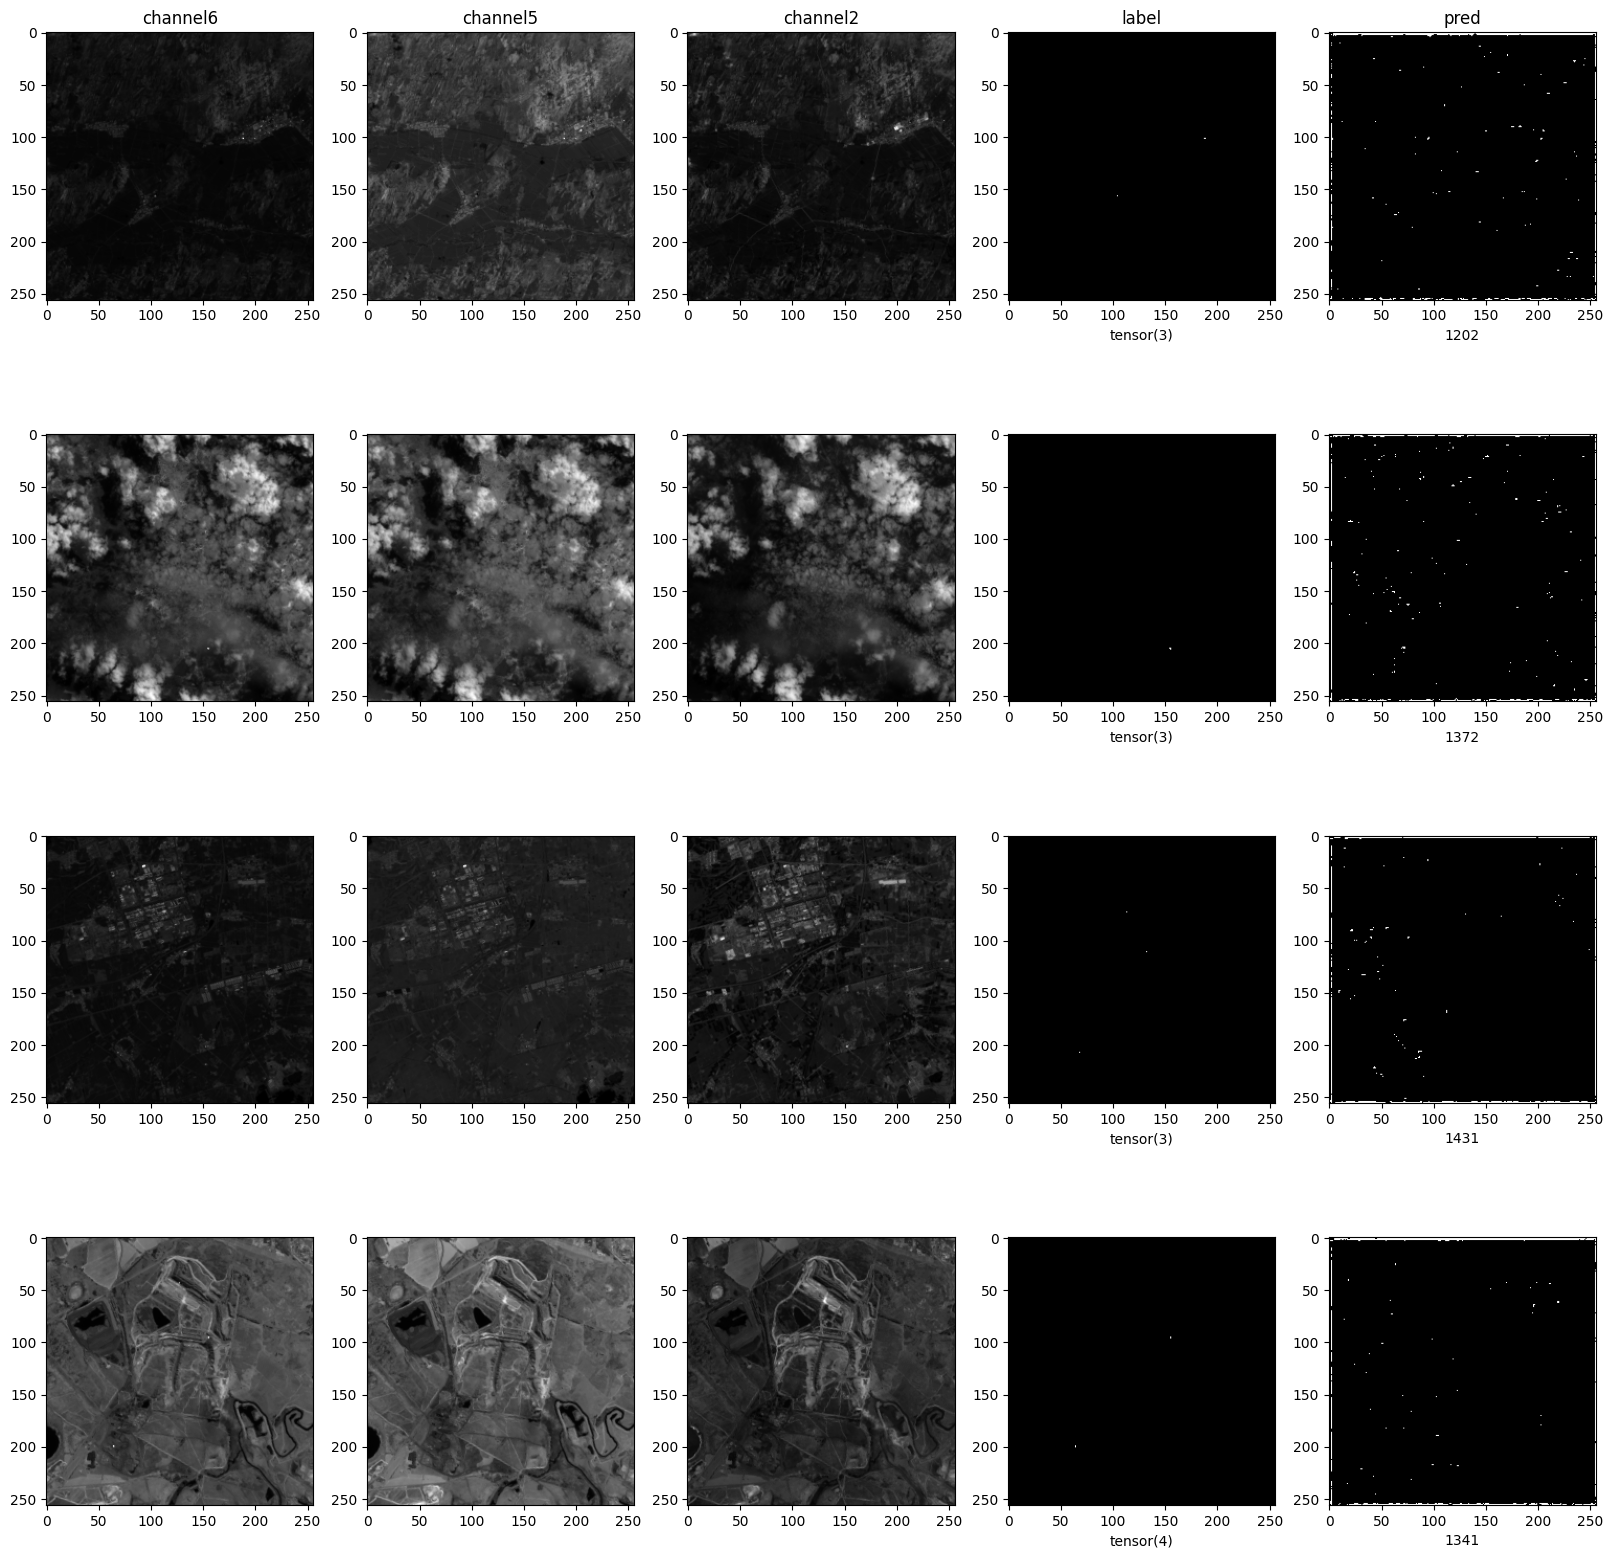

In [47]:
val_preds = joblib.load(valid_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+2)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('label')
axs[0,i+2].set_title('pred')
cnt=0
for idx,(imgs, masks) in enumerate(train_loader):
    print(imgs.shape)
    for i in range(len(imgs)):
        for j in range(len(config['channels'])):
            axs[i,j].imshow(imgs[i,j,:,:],cmap='gray')
        axs[i,-2].imshow(masks[i,0,:,:],cmap='gray')
        axs[i,-2].set_xlabel(str(masks[i,0,:,:].sum().sum()))
        axs[i,4].imshow(val_preds[str(idx*config['batch_size']+i)],cmap='gray')
        axs[i,4].set_xlabel(str(val_preds[str(idx*config['batch_size']+i)].sum().sum()))
        cnt+=1
        if cnt==num_imgs_to_show:
            break
    if cnt==num_imgs_to_show:
        break

## 8. Inference Viewer

In [48]:
num_imgs_to_show = 4
test_save_path = './y_pred.pkl'
test_preds = joblib.load(test_save_path)

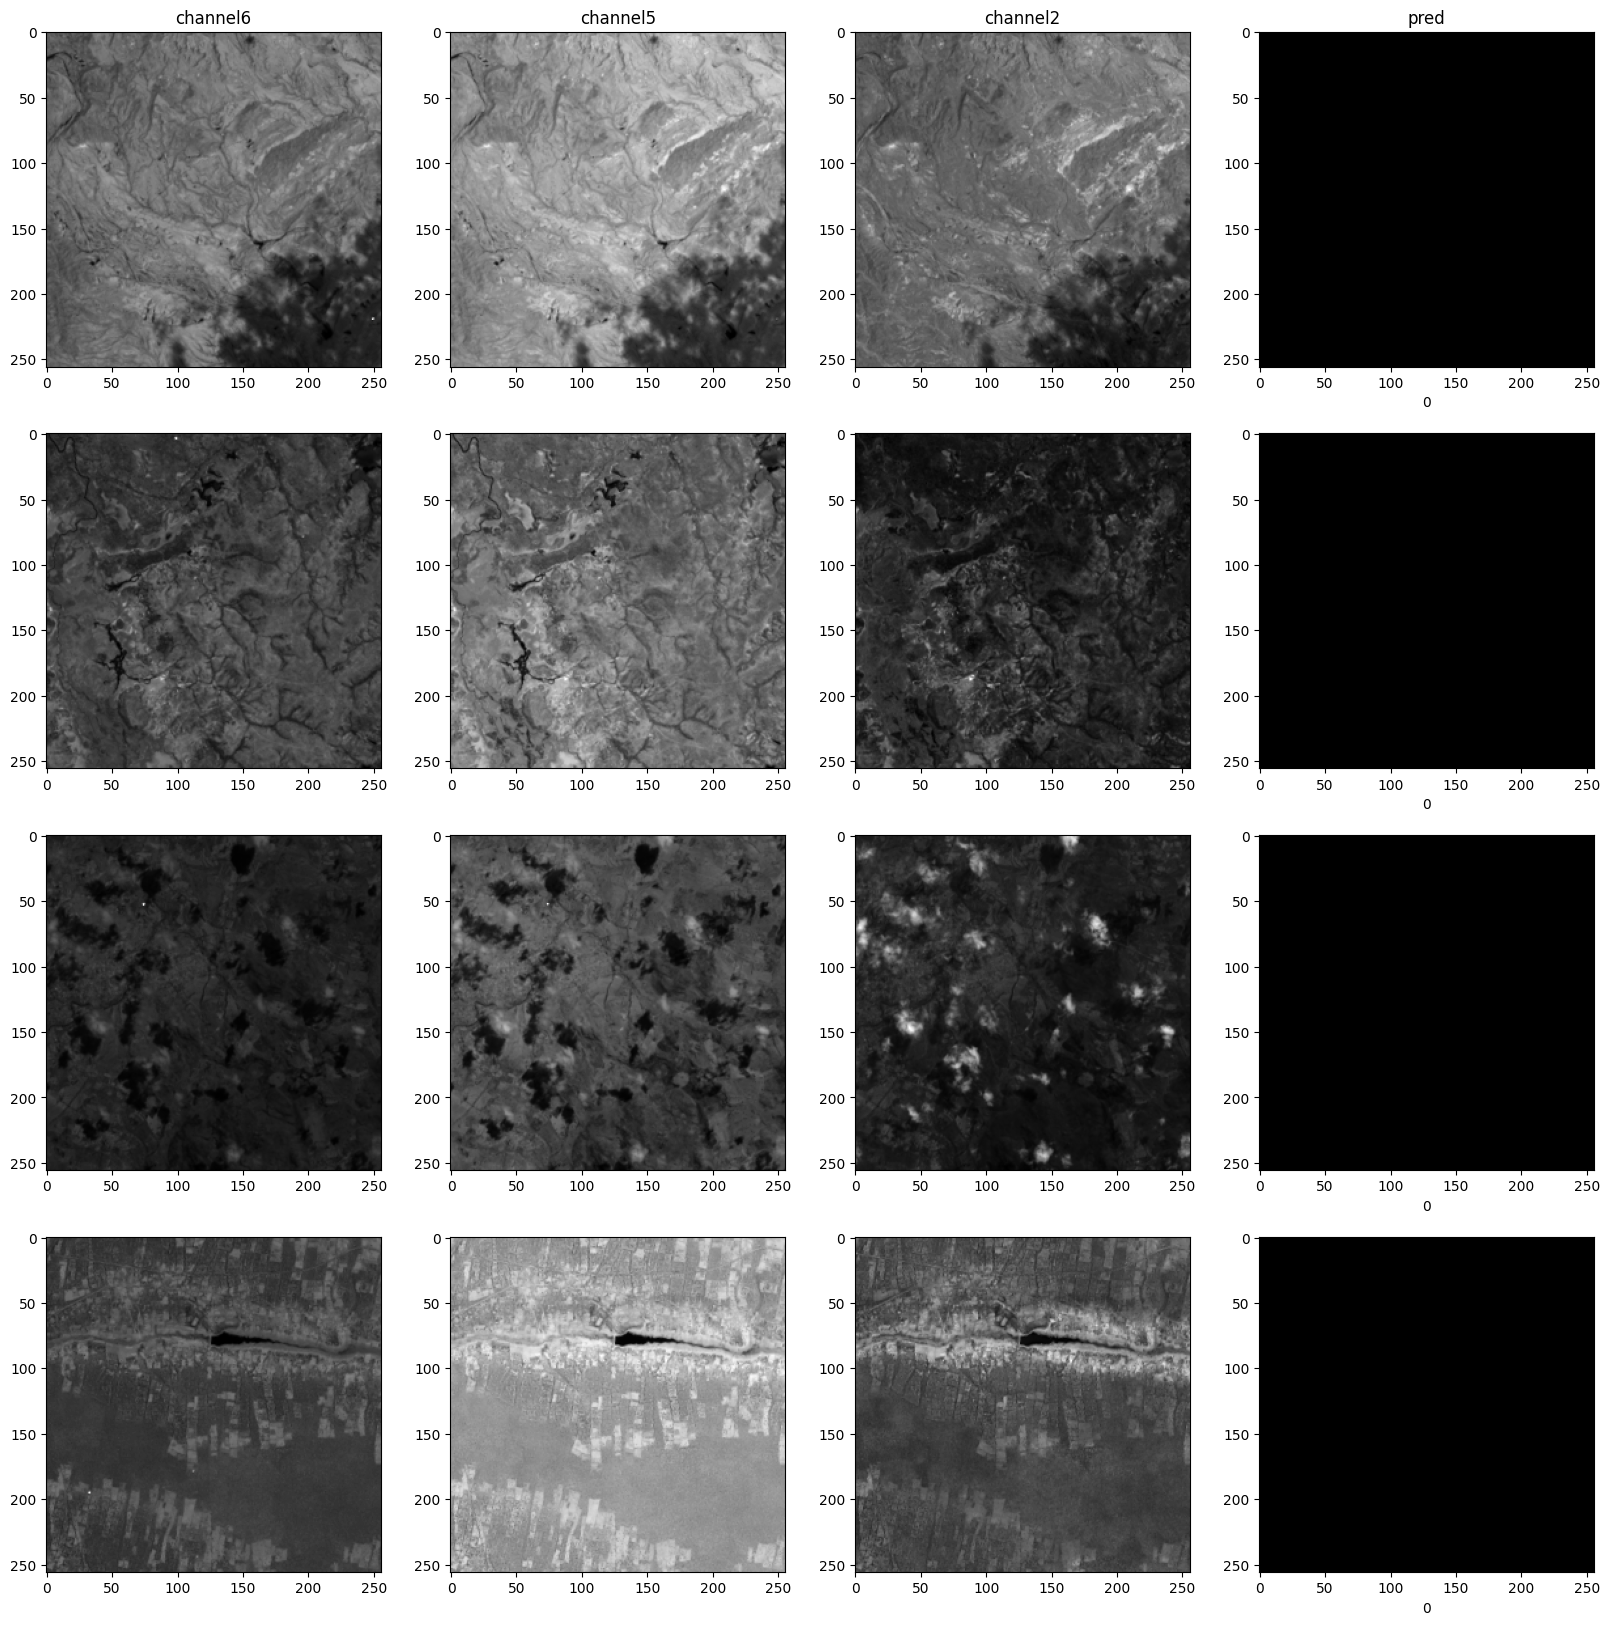

In [49]:
test_preds = joblib.load(test_save_path)
fig,axs = plt.subplots(num_imgs_to_show,len(config['channels'])+1)
fig.set_figheight(20)
fig.set_figwidth(20)
for i in range(len(config['channels'])):
    axs[0,i].set_title('channel'+ str(config['channels'][i]))
axs[0,i+1].set_title('pred')
cnt=0
for (imgs) in (test_loader):
    for j in range(len(config['channels'])):
        axs[cnt,j].imshow(imgs[0,j,:,:],cmap='gray')
    axs[cnt,-1].imshow(test_preds[cnt],cmap='gray')
    axs[cnt,-1].set_xlabel(str(test_preds[cnt].sum().sum()))
    cnt+=1
    if cnt==num_imgs_to_show:
        break